In [1]:
from datasets import load_dataset

In [2]:
dataset = load_dataset("pemujo/GLDv2_Top_51_Categories")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'landmark_id', 'category', 'image', 'label'],
        num_rows: 36463
    })
    test: Dataset({
        features: ['id', 'landmark_id', 'category', 'image', 'label'],
        num_rows: 9116
    })
})


In [ ]:
from collections import Counter
counts = Counter(dataset["train"]["label"])

In [ ]:
labels = [label for label in range(len(counts))]

In [17]:
dataset["train"]

Dataset({
    features: ['id', 'landmark_id', 'category', 'image', 'label'],
    num_rows: 36463
})

In [19]:
# mapping from label to name eg. 0 -> Eifeltower
label_to_name = {}
for example in dataset["train"]:
    lbl = example["label"]

    if lbl in top_labels:
        label_to_name[lbl] = example["category"]

    if len(label_to_name) == len(top_labels):
        break

#print labels and names in made nice

from urllib.parse import unquote

def pretty(name):
    return unquote(name).replace("_", " ")

for k, v in label_to_name.items():
    print(k, "->", pretty(v))

26 -> Qutb Minar and its monuments, Delhi
42 -> Media contributed by the ETH-Bibliothek
28 -> Salève
22 -> Corktown, Toronto
19 -> Golden Gate Bridge
41 -> Nieuwe Waterweg
2 -> Niagara Falls
31 -> St. Lawrence, Toronto
3 -> Matka Canyon
12 -> Ljubljana Castle
29 -> Noraduz Cemetery
27 -> Perperikon
50 -> Pešter
39 -> Edinburgh Castle
8 -> Pakistan Monument Islamabad
21 -> Jurassic Coast
7 -> Grote of Onze-Lieve-Vrouwekerk (Breda)
38 -> Khotyn Fortress
5 -> Kecharis
40 -> Harichavank
44 -> Madrid Río
35 -> Douthat State Park
9 -> Hayravank monastery
13 -> Masada
34 -> Lviv
6 -> Saint Holy Mother church of Yeghvard
46 -> Grand Canyon
25 -> Episcopal Diocese of Southwest Florida
14 -> Victoria Memorial, Kolkata
18 -> Mathura Museum
15 -> Catedral San Sebastián, Cochabamba
33 -> Museum of Folk Architecture and Ethnography in Pyrohiv
36 -> Skopje Fortress
43 -> Faisal Mosque
10 -> Eiffel Tower
37 -> Itmad-Ud-Daulah's Tomb
45 -> Feroz Shah Kotla
32 -> Purana Qila
16 -> Isa Khan Niyazi's tomb

In [20]:
keep_names = ("Niagara Falls", "Golden Gate Bridge", "Eiffel Tower","Grand Canyon","Lake Como","Masada","Edinburgh Castle","Victoria Memorial, Kolkata","Faisal Mosque", "Jurassic Coast")
keep_indices = []

for i, ex in enumerate(dataset["train"]):
    cat = pretty(ex["category"])
    if cat in keep_names:
        keep_indices.append(i)

# build new dataset with filtered landmarks

filtered_dataset = dataset["train"].select(keep_indices)

In [21]:
len(filtered_dataset), len(dataset["train"])

(5667, 36463)

In [22]:
unique_cat = sorted(list(keep_names))
unique_cat

['Edinburgh Castle',
 'Eiffel Tower',
 'Faisal Mosque',
 'Golden Gate Bridge',
 'Grand Canyon',
 'Jurassic Coast',
 'Lake Como',
 'Masada',
 'Niagara Falls',
 'Victoria Memorial, Kolkata']

In [24]:
filtered_dataset[0]

{'id': '5ee241bae2d9b97f',
 'landmark_id': 168098,
 'category': 'Golden_Gate_Bridge',
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 'label': 19}

In [79]:
label_mapping = {}

for i, cat in enumerate(unique_cat):
    label_mapping[cat] = i

def relabel_example(ex):
    cat = pretty(ex["category"])
    new_ex = ex.copy()
    new_ex["label"] = label_mapping[cat]
    return new_ex

data = filtered_dataset.map(relabel_example)

In [96]:
# validation set
splits = data.train_test_split(test_size=0.1, seed=42)
train_split = splits["train"]
val_split = splits["test"]

In [102]:
# test_set
keep_names = ("Niagara Falls", "Golden Gate Bridge", "Eiffel Tower","Grand Canyon","Lake Como","Masada","Edinburgh Castle","Victoria Memorial, Kolkata","Faisal Mosque", "Jurassic Coast")
keep_indices = []

for i, ex in enumerate(dataset["test"]):
    cat = pretty(ex["category"])
    if cat in keep_names:
        keep_indices.append(i)
filtered_test = dataset["test"].select(keep_indices)

test_split = filtered_test.map(relabel_example)

Map:   0%|          | 0/1387 [00:00<?, ? examples/s]

In [105]:
train_split[0]

{'id': '8c4c18b46d5deb49',
 'landmark_id': 64792,
 'category': 'Victoria_Memorial,_Kolkata',
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 'label': 9}

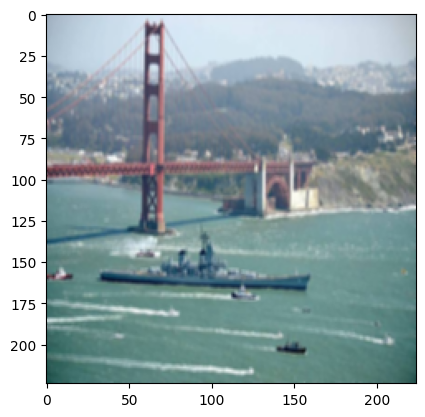

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_split[7]["image"])

In [159]:
# prepare tranforms
import torch
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(), # from (224,224,3) Werte 0-255 -> (3,224,224) Werte: 0-1
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) # per channdel: x_norm = (x-mean) / std
])

# same transorm, but first gonna be extended -> two separat
eval_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))
])


In [160]:
# pytorch dataset wrapper

class HFDatasetTorch:
    def __init__(self, hf_dataset, transform):
        self.hf_dataset = hf_dataset
        self.transform = transform
    
    #pytorch benötigt nur diese beiden methoden und kann dann damit arbeiten

    def __len__(self):
        return len(self.hf_dataset)
    
    def __getitem__(self, idx):
        img = self.hf_dataset[idx]["image"]
        x = self.transform(img)
        y = int(self.hf_dataset[idx]["label"])
        return x, y
    
train_ds = HFDatasetTorch(train_split, train_transform)
val_ds = HFDatasetTorch(val_split, eval_transform)
test_ds = HFDatasetTorch(test_split, eval_transform)

In [161]:
from torch.utils.data import DataLoader

# build DataLoader
train_loader = DataLoader(dataset= train_ds, batch_size= 8, shuffle= True) #shuffel -> vor jeder epoch daten shuffel
val_loader = DataLoader(dataset= val_ds, batch_size= 8)
test_loader = DataLoader(dataset= test_ds, batch_size= 8)


In [162]:
# sanity check if laoder works
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8]))

### data handling finsihed -> model

In [2]:
import torch
import torch.nn as nn
from torchvision import models

In [4]:
model = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)
model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [192]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [193]:
in_features = model.fc.in_features
in_features

512

### last linear layer - classifikation - traineiren

In [196]:
model.fc = nn.Linear(in_features, 10) #letzte Schicht neu definieren mit 10 Ausgaben
model.fc

Linear(in_features=512, out_features=10, bias=True)

In [197]:
# gradienten freezen außer in letzter Schicht
for p in model.parameters():
    p.requires_grad = False
for p in model.fc.parameters():
    p.requires_grad = True

for name, p in model.named_parameters():
    if p.requires_grad == True:
        print(name)

fc.weight
fc.bias


In [307]:
def train(model, loader, criterion, optimizer, num_epochs, device):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total = 0 # count of samples per epoch
        running_loss = 0.0 #sum of loss over all samples per epoch
        eval_loss = 0.0
        val_total = 0
        val_correct = 0
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)

            running_loss += loss.item() * labels.shape[0]
            total += labels.shape[0]

            loss.backward()
            optimizer.step()
        
        epoch_loss = running_loss / total

        model.eval()
        with torch.no_grad():
            for i, (images, labels) in enumerate(val_loader):
                images, labels = images.to(device), labels.to(device)
                logits = model(images)
                loss = criterion(logits, labels)
                preds = logits.argmax(dim=1)
                correct_in_batch = (preds == labels).sum().item()
                
                val_correct += correct_in_batch
                
                eval_loss += loss.item() * labels.shape[0]
                val_total += labels.shape[0]
                
        val_acc = val_correct / val_total
        val_epoch_loss = eval_loss / val_total
        
        print(f"Epoch: {epoch+1} | Train-Loss: {epoch_loss:.4f} | Val-Loss: {val_epoch_loss:.4f} | Accuracy: {val_acc:.4f}")

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.fc.parameters(), lr = 1e-4)
device = torch.device("mps") if torch.mps.is_available() else torch.device("cpu")
print(device)

num_epochs = 20

train(model, train_loader, criterion, optimizer, num_epochs, device)

### layer4 unfreezen and training

In [199]:
for p in model.parameters():
    p.requires_grad = False
for p in model.fc.parameters():
    p.requires_grad = True
for p in model.layer4.parameters():
    p.requires_grad = True

for name, p in model.named_parameters():
    if p.requires_grad == True:
        print(name)

optimizer = torch.optim.Adam([
    {"params": model.layer4.parameters(), "lr": 1e-5},
    {"params": model.fc.parameters(), "lr": 1e-4}
])

layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
device = torch.device("mps") if torch.mps.is_available() else torch.device("cpu")
print(device)

num_epochs = 15
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total = 0 # count of samples per epoch
    running_loss = 0.0 #sum of loss over all samples per epoch
    eval_loss = 0.0
    val_total = 0
    val_correct = 0
    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)

        running_loss += loss.item() * labels.shape[0]
        total += labels.shape[0]

        loss.backward()
        optimizer.step()
    
    epoch_loss = running_loss / total

    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            preds = logits.argmax(dim=1)
            correct_in_batch = (preds == labels).sum().item()
            
            val_correct += correct_in_batch
            
            eval_loss += loss.item() * labels.shape[0]
            val_total += labels.shape[0]
            
    val_acc = val_correct / val_total
    val_epoch_loss = eval_loss / val_total
    
    print(f"Epoch: {epoch+1} | Train-Loss: {epoch_loss:.4f} | Val-Loss: {val_epoch_loss:.4f} | Accuracy: {val_acc:.4f}")

mps
Epoch: 1 | Train-Loss: 0.3718 | Val-Loss: 0.2217 | Accuracy: 0.9295
Epoch: 2 | Train-Loss: 0.2507 | Val-Loss: 0.1857 | Accuracy: 0.9383
Epoch: 3 | Train-Loss: 0.1756 | Val-Loss: 0.1660 | Accuracy: 0.9383
Epoch: 4 | Train-Loss: 0.1337 | Val-Loss: 0.1473 | Accuracy: 0.9524
Epoch: 5 | Train-Loss: 0.1021 | Val-Loss: 0.1447 | Accuracy: 0.9471
Epoch: 6 | Train-Loss: 0.0687 | Val-Loss: 0.1288 | Accuracy: 0.9453
Epoch: 7 | Train-Loss: 0.0554 | Val-Loss: 0.1266 | Accuracy: 0.9612
Epoch: 8 | Train-Loss: 0.0459 | Val-Loss: 0.1200 | Accuracy: 0.9612
Epoch: 9 | Train-Loss: 0.0449 | Val-Loss: 0.1226 | Accuracy: 0.9577
Epoch: 10 | Train-Loss: 0.0356 | Val-Loss: 0.1308 | Accuracy: 0.9524
Epoch: 11 | Train-Loss: 0.0267 | Val-Loss: 0.1260 | Accuracy: 0.9594
Epoch: 12 | Train-Loss: 0.0232 | Val-Loss: 0.1216 | Accuracy: 0.9612
Epoch: 13 | Train-Loss: 0.0260 | Val-Loss: 0.1257 | Accuracy: 0.9612
Epoch: 14 | Train-Loss: 0.0198 | Val-Loss: 0.1181 | Accuracy: 0.9630
Epoch: 15 | Train-Loss: 0.0172 | Val-Lo

In [201]:
torch.save(model.state_dict(), "ft_model.pth")

### test

In [222]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_correct = 0
    total = 0
    total_loss = 0.0
    with torch.no_grad():    
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            total_loss += loss.item() * labels.shape[0]
            preds = logits.argmax(dim=1)
            correct = (preds == labels).sum().item()
            total_correct += correct
            total += labels.shape[0]

    test_acc = total_correct / total
    avg_loss = total_loss / total
    print(f"Accuracy: {test_acc:.4f} | Loss: {avg_loss:.4f}")

evaluate(model, test_loader, criterion, device)



Accuracy: 0.9740 | Loss: 0.0814


### corruption:

In [302]:
from torchvision import transforms

corr_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(224, scale=(0.6, 0.6), ratio=(1, 1)), #crop
    transforms.GaussianBlur(kernel_size=7, sigma= 1.5), #blur
    transforms.ColorJitter(brightness=0.6, contrast = 0.6),# lighting
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
]) 

test_corr_ds = HFDatasetTorch(test_split, corr_transform)
test_corr_loader = DataLoader(dataset= test_corr_ds, batch_size= 8, shuffle= False)

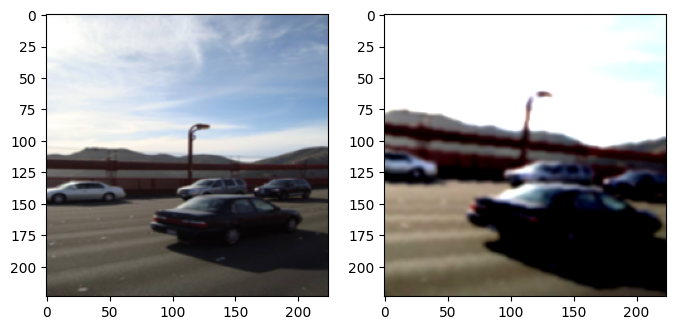

In [303]:
from helpers import unnormalize
import random

idx = random.randint(0, 100) 

x_corr, y_corr = test_corr_ds[idx]
x_clean, y_clean = test_ds[idx]

x_vis_clean = unnormalize(x_clean).permute(1,2,0) # C,H,W → H,W,C
x_vis_corr = unnormalize(x_corr).permute(1,2,0) # C,H,W → H,W,C

fig, axs = plt.subplots(1,2, figsize= (8,4))

axs[0].imshow(x_vis_clean)
axs[1].imshow(x_vis_corr)


In [304]:
evaluate(model, test_corr_loader, criterion, device)

Accuracy: 0.7635 | Loss: 0.8119


### improve robustness - training on clean AND corrupted

In [309]:
train_robust_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomApply([ # hälfte clean, hälfte corrupted
        transforms.RandomRotation(degrees=10),
        transforms.RandomResizedCrop(224, scale=(0.6, 1.0), ratio=(0.8, 1.25)),
        transforms.GaussianBlur(kernel_size=7, sigma=(0.8, 1.8)),
        transforms.ColorJitter(brightness=(0.2, 0.6), contrast=(0.2, 0.6)),
    ], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

train_robust_ds = HFDatasetTorch(train_split, transform=train_robust_transform)
train_robust_loader = DataLoader(train_robust_ds, batch_size=8, shuffle= True)

In [310]:
train(model, train_robust_loader, criterion, optimizer, num_epochs, device)

Epoch: 1 | Train-Loss: 0.0172 | Val-Loss: 0.1003 | Accuracy: 0.9683
Epoch: 2 | Train-Loss: 0.0126 | Val-Loss: 0.1239 | Accuracy: 0.9594
Epoch: 3 | Train-Loss: 0.0142 | Val-Loss: 0.1192 | Accuracy: 0.9559
Epoch: 4 | Train-Loss: 0.0144 | Val-Loss: 0.1164 | Accuracy: 0.9647
Epoch: 5 | Train-Loss: 0.0120 | Val-Loss: 0.1100 | Accuracy: 0.9594
Epoch: 6 | Train-Loss: 0.0116 | Val-Loss: 0.1173 | Accuracy: 0.9630
Epoch: 7 | Train-Loss: 0.0080 | Val-Loss: 0.1076 | Accuracy: 0.9665
Epoch: 8 | Train-Loss: 0.0082 | Val-Loss: 0.1187 | Accuracy: 0.9594
Epoch: 9 | Train-Loss: 0.0078 | Val-Loss: 0.1051 | Accuracy: 0.9630
Epoch: 10 | Train-Loss: 0.0083 | Val-Loss: 0.1193 | Accuracy: 0.9612
Epoch: 11 | Train-Loss: 0.0064 | Val-Loss: 0.1132 | Accuracy: 0.9612
Epoch: 12 | Train-Loss: 0.0080 | Val-Loss: 0.1188 | Accuracy: 0.9612
Epoch: 13 | Train-Loss: 0.0074 | Val-Loss: 0.1296 | Accuracy: 0.9665
Epoch: 14 | Train-Loss: 0.0054 | Val-Loss: 0.1044 | Accuracy: 0.9647
Epoch: 15 | Train-Loss: 0.0072 | Val-Loss: 